In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pickle
from IPython.display import YouTubeVideo

import keras

Using TensorFlow backend.


# Generative Adversarial Networks
In this exercise you will extend the generative adversarial model we did in the [GAN session](../sessions/GAN.ipynb) so that the generator recieves the **specific digit to be generated**, and the discriminator not only decides if an image is "fake" or "real", but also classifies the digit in the image. 
The framework I suggest you use is the [Auxiliary Classifier Generative Adversarial Network](https://arxiv.org/abs/1610.09585) where the "auxiliary classifier" is the additional classifier employed by the discriminator. This is instead of using two separate discriminators.

This can be considered a "hard" exercise. You'll probably want to read a bit and search the web a bit as there is a conceptual "jump" between GAN and ACGAN in terms of the implementation.
Still, much of the code from the [GAN session](../sessions/GAN.ipynb) can be reused here.

You can find a code example on the [Keras repo](https://github.com/keras-team/keras/blob/master/examples/mnist_acgan.py) or check the [solution](../solutions/ACGAN.ipynb), but I suggest you try doing it yourself before you look at the code. 

The movie below shows the digits generated by the network in the [solution](../solutions/ACGAN.ipynb).

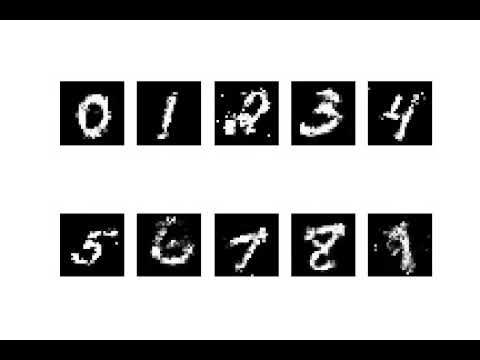

In [43]:
YouTubeVideo('-h-5YCfQUVU')

Basic parameters:

In [2]:
img_rows = 28 
img_cols = 28
channels = 1
n_class = 10
img_shape = (img_rows, img_cols, channels)
input_shape = img_shape

# Adam parameters suggested in https://arxiv.org/abs/1511.06434
optimizer = keras.optimizers.Adam(0.0002, 0.5)

For the discriminator, we build a FFN with two dense layers to generate features. 
We then give those feaures to two readout layers - one logistic regression and one softmax.
The first will discriminate between "fake" and "real" images, the second will classify the digit in the image.

In [3]:
layers = [
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(256),
    keras.layers.LeakyReLU(alpha=0.2)
]
ffn = keras.models.Sequential(layers)

img = keras.Input(shape=img_shape)
features = ffn(img)

validation = keras.layers.Dense(1, activation='sigmoid', name='validation')(features) 
calssification = keras.layers.Dense(10, activation='softmax', name='calssification')(features) 

The discriminator is then built from the input `img` and the two outputs.
The second loss function is "sparse" because we will encode the classes (digits) with embedding rather than one-hot encoding (see below).

In [4]:
discriminator = keras.models.Model(img, [validation, calssification], name='discriminator')
discriminator.compile(
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
    optimizer=optimizer,
    metrics=['accuracy']
)

The generator still accepts 100 inputs and generates the 28x28x1 image, but the input is not just "noise" (random numbers).
We get a digit (integer), embed (i.e. map) it in a real vector of length 100, and multiply that vector with the noise vector.
So in essence, we create one-to-many noisy representations of the digits as inputs to the generator.

You can read more about [embedding](http://colah.github.io/posts/2014-07-NLP-RNNs-Representations/) if you'd like.

In [5]:
noise_shape = (100,)

layers = [
    keras.layers.Dense(256, input_shape=noise_shape),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(1024),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(np.prod(img_shape), activation='tanh'),
    keras.layers.Reshape(img_shape)
]
ffn = keras.models.Sequential(layers)

noise = keras.Input(shape=noise_shape)
img_class = keras.Input(shape=(1,), dtype='int32')
embedding = keras.layers.Embedding(n_class, noise_shape[0], 
                                   embeddings_initializer='glorot_normal')
clazz = embedding(img_class)
flatten = keras.layers.Flatten()
clazz = flatten(clazz)

# elementwise product between z-space and a class conditional embedding
h = keras.layers.multiply([noise, clazz])
img = ffn(h)

In [6]:
generator = keras.models.Model([noise, img_class], img, name='generator')
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

The generator takes noise as input and generated imgs

In [7]:
img = generator([noise, img_class])

The combined model will take noise and digit and produce "fake"/"real" boolean and an image classification label.

For the combined model we will only train the generator

In [8]:
discriminator.trainable = False

The valid takes generated images as input and determines validity

In [9]:
valid, labels = discriminator(img)

The combined model  (stacked generator and discriminator) takes
noise as input => generates images => determines validity 

In [10]:
combined = keras.models.Model([noise, img_class], [valid, labels])
combined.compile(
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
    optimizer=optimizer
)

Function to save generated images

In [11]:
def save_imgs(idx):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    labels = np.arange(10)
    gen_imgs = generator.predict([noise, labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("../data/acgan/mnist_{:05d}.png".format(idx))
    plt.close()

Load the dataset

In [12]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
X_test = (X_test.astype(np.float32) - 127.5) / 127.5
X_test = np.expand_dims(X_test, axis=3)

num_train, num_test = X_train.shape[0], X_test.shape[0]

Training the ACGAN is similar to training the GAN, but the loss is now calculated by two factors - the validation and the classification. We give both tasks equal weight, but we don't want to train train the discriminator's classification task on "fake" images.
We can do that by giving Keras a weight vector. We will give it 16 real images and 16 fake images in each batch, so the weights will 32 1s for the first task, the validation (`np.ones(batch_size)`), whereas for the second task, the classification, we will have 16 2s followed by 16 0s (`np.concatenate((np.ones(half_batch) * 2, p.zeros(half_batch)))` so that the loss from classification of "fake" images will be disregarded and the loss from classification of "real" images will take it's place.
Of course, for training the generator we do want to account for the "fake" images classification, so we don't provide Keras with a weight.

In [13]:
epochs = 5000
batches_per_epoch = 10
batch_size = 32
half_batch = int(batch_size / 2)
save_interval = 1
print_interval = 1
nimages = X_train.shape[0]

train_history = defaultdict(list)
test_history = defaultdict(list)

d_sample_weight = [
    np.ones(batch_size),
    np.concatenate((
        np.ones(half_batch) * 2,
        np.zeros(half_batch)
    ))
]

In [87]:
for epoch in range(epochs):
    for batch in range(batches_per_epoch):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, nimages, half_batch)
        real_imgs = X_train[idx]
        true_labels = Y_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        sampled_labels = np.random.randint(0, n_class, half_batch)

        # Generate a half batch of new images
        gen_imgs = generator.predict([noise, sampled_labels])

        # Train the discriminator
        imgs = np.concatenate((real_imgs, gen_imgs))
        valid = np.concatenate((np.ones(half_batch), np.zeros(half_batch)))
        label = np.concatenate((true_labels, sampled_labels))
        d_loss = discriminator.train_on_batch(
            imgs, 
            [valid, label], 
            sample_weight=d_sample_weight
        )

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, 100))
        sampled_labels = np.random.randint(0, n_class, batch_size)

        # The generator wants the discriminator to label the generated samples as valid (ones)
        valid = np.ones(batch_size)

        # Train the generator
        g_loss = combined.train_on_batch(
            [noise, sampled_labels], 
            [valid, sampled_labels]
        )
        train_history['dloss'].append( d_loss )
        train_history['gloss'].append( g_loss )
    
    # test discriminator
    noise = np.random.normal(0, 1, (num_test, 100))
    sampled_labels = np.random.randint(0, n_class, num_test)
    gen_imgs = generator.predict([noise, sampled_labels])
    x = np.concatenate((X_test, gen_imgs))
    y_valid = np.ones(num_test*2)
    y_valid[num_test:] = 0
    y_class = np.concatenate((Y_test, sampled_labels), axis=0)
    
    d_test_loss = discriminator.evaluate(x, [y_valid, y_class])
    
    # test generator
    noise = np.random.normal(0, 1, (num_test, 100))
    sampled_labels = np.random.randint(0, n_class, num_test)
    valid_y = np.ones(num_test)    
    g_test_loss = combined.evaluate(
        [noise, sampled_labels], 
        [valid_y, sampled_labels]
    )
    
    test_history['dloss'].append( d_test_loss )
    test_history['gloss'].append( g_test_loss )
    
    # print the progress
    if (epoch) % print_interval == 0:
        print("Epoch {}: D train loss {}, G train loss {} D test loss {}, G test loss {}".format(
            epoch, d_loss[0], g_loss[0], d_test_loss[0], g_test_loss[0]))
    # If at save interval => save generated image samples
    if epoch % save_interval == 0:
        save_imgs(epoch//save_interval)

/Users/yoavram/miniconda3/envs/Deep4Devs/lib/python3.6/site-packages/keras/engine/training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10000/10000 [==============================] - 2s 211us/step
Epoch 0: D train loss 4.487121105194092, G train loss 3.0603747367858887 D test loss 2.4596286657333373, G test loss 3.022113102722168
10000/10000 [==============================] - 2s 156us/step
Epoch 1: D train loss 3.116650104522705, G train loss 3.245912551879883 D test loss 2.091346453666687, G test loss 3.239784167098999
10000/10000 [==============================] - 1s 139us/step
Epoch 2: D train loss 2.132068634033203, G train loss 3.5056214332580566 D test loss 1.8542716453552246, G test loss 3.4275369235992432
10000/10000 [==============================] - 1s 140us/step
Epoch 3: D train loss 2.308821678161621, G train loss 3.7472641468048096 D test loss 1.6713025757789612, G test loss 3.5770454681396484
10000/10000 [==============================] - 1s 114us/step
Epoch 4: D train loss 1.262225866317749, G train loss 3.693105459213257 D test loss 1.602113617658615, G test loss 3.655064033508301
10000/10000 [=========

In [88]:
generator.save('../data/acgan_generator.h5')
discriminator.save('../data/acgan_discriminator.h5')
combined.save('../data/acgan_combined.h5')

In [89]:
with open('../data/acgan_history.p', 'wb') as f:
    pickle.dump([train_history, test_history], f)

Plot history:

In [4]:
with open('../data/acgan_history.p', 'rb') as f:
    train_history, test_history = pickle.load(f)

In [33]:
__, _, _, tr_val_acc, tr_class_acc = np.array(train_history['dloss']).T
__, _, _, te_val_acc, te_class_acc = np.array(test_history['dloss']).T

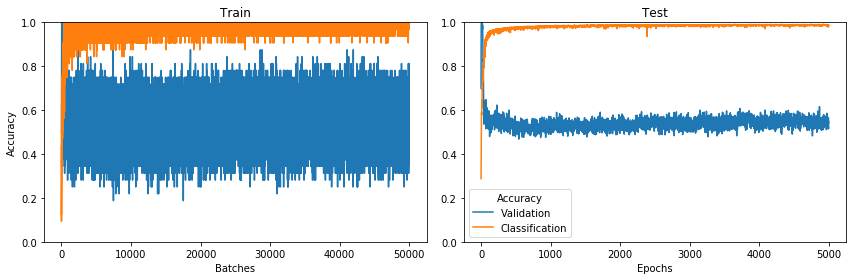

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(tr_val_acc, label='Validation')
ax.plot(tr_class_acc, label='Classification')
ax.set(ylim=(0, 1), xlabel='Batches', title='Train', ylabel='Accuracy')
# ax.legend(title='Accuracy')

ax = axes[1]
ax.plot(te_val_acc, label='Validation')
ax.plot(te_class_acc, label='Classification')
ax.set(ylim=(0, 1), xlabel='Epochs', title='Test')
ax.legend(title='Accuracy')
fig.tight_layout()

Generate digits:

In [79]:
generator = keras.models.load_model('../data/acgan_generator.h5')

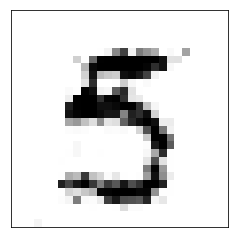

In [87]:
digit = 5

noise = np.random.normal(0, 1, 100).reshape(1, -1)
digit = np.array(digit).reshape(1, -1)
gen_img = generator.predict([noise, digit]).squeeze()
# Rescale images 0 - 1
gen_img = 0.5 * gen_img + 0.5
plt.imshow(gen_img, cmap='gray_r')
plt.xticks([])
plt.yticks([]);